In [2]:
!unzip -q -o /datasets/sharetextures/sharetextures.com-20221007T082809Z-001.zip -d /notebooks/data/sharetextures

In [1]:
# from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
keras = tf.keras

In [18]:
DATA_DIRECTORY = "/notebooks/data/sharetextures/sharetextures.com/"

## Tuple parameters: (color_mode, offset, fill_value, channels)
MAP_KEYS = {"color": ("rgb", 0, 128, 3), "normaldx": ("rgb", 3, 128, 3), "metal": ("grayscale", 6, 0, 1), "rough": ("grayscale", 7, 128, 1)}

def get_default_map(details, target_size):
    shape = target_size + (details[3],)
    return np.full(shape=shape, fill_value=details[2], dtype="float32")

## Loads all materials based on the content.csv in the specified directory.
## Each material is a tensor of rank 3 (width, height, channels=8)
## The returned tensor is therefore of rank 4.
def get_materials(directory_path, target_size):
    ids = np.loadtxt(directory_path + "/content.csv", delimiter=",", dtype=str, usecols=(0))[1:]
    number_of_materials = len(ids)
    materials = np.zeros(shape=(number_of_materials,) + target_size + (8,))
    for (i, id) in enumerate(ids):
        image = np.zeros(shape=target_size + (8,))
        for map_key, details in MAP_KEYS.items():
            map_path = f"{directory_path}/{id}_{map_key}.jpg"
            if os.path.exists(map_path):
                map = keras.utils.load_img(
                    path=map_path,
                    color_mode=details[0],
                    target_size=target_size,
                    # keep_aspect_ratio=True
                )
                map = keras.utils.img_to_array(map)
            else:
                map = get_default_map(MAP_KEYS[map_key], target_size)
            for channel_index in range(map.shape[-1]):
                image[:,:,details[1] + channel_index] = map[:,:,channel_index]
        materials[i,:,:,:] = image
    return materials

target_size = (128, 128)
        
materials = get_materials(DATA_DIRECTORY, target_size).astype("float32")
materials /= 255.
# def load_data(root_directory_path):
#     all_images = []
#     directory = os.fsencode(root_directory_path)
#     for file in os.listdir(directory):
#         filename = os.fsdecode(file)
#         if filename.endswith("_data"):



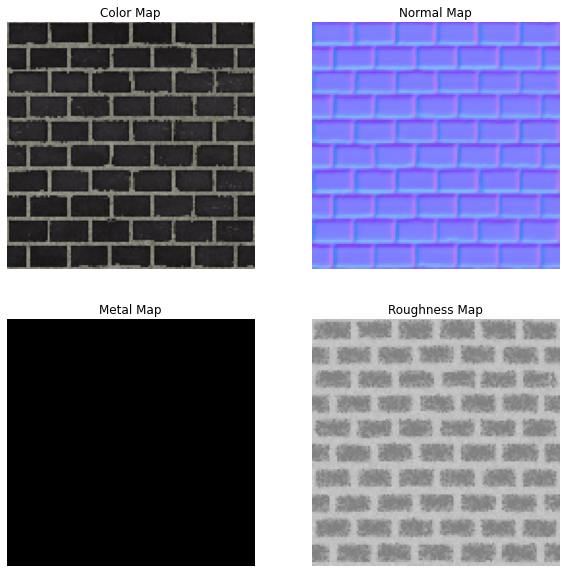

In [28]:
def plot_sample(materials, sample_number=120):
    sample = materials[sample_number,:,:,:]
    sample *= 255
    sample = sample.astype(np.uint8)
    plt.figure(figsize=(10,10))

    plt.subplot(2, 2, 1)
    plt.axis("off")
    plt.title("Color Map")
    plt.imshow(sample[:,:,:3])

    plt.subplot(2, 2, 2)
    plt.axis("off")
    plt.title("Normal Map")
    plt.imshow(sample[:,:,3:6])

    plt.subplot(2, 2, 3)
    plt.axis("off")
    plt.title("Metal Map")
    plt.imshow(sample[:,:,6:7], cmap='gray', vmin=0, vmax=255)

    plt.subplot(2, 2, 4)
    plt.axis("off")
    plt.title("Roughness Map")
    plt.imshow(sample[:,:,7:8], cmap='gray', vmin=0, vmax=255)

plot_sample(materials, 90)

In [11]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=target_size + (8,)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid")
    ],
    name="discriminator"
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        8256      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)       131200    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       262272    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 flatten_1 (Flatten)         (None, 32768)           

In [12]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(16*16*128),
        layers.Reshape((16,16,128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(8, kernel_size=5, padding="same", activation="sigmoid")
    ],
    name="generator"
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32768)             4227072   
                                                                 
 reshape_1 (Reshape)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 64, 64, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 64, 64, 256)       0 

In [13]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")
    
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]
    
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        labels += 0.005 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [23]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
    
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i,:,:,:3])
            img.save(f"generated/generated_img_{epoch:03d}_{i}.png")

In [24]:
epochs = 50

callbacks = [
    GANMonitor(num_img=3, latent_dim=latent_dim),
    # keras.callbacks.ModelCheckpoint(
    #     filepath="duetpbr_gan.keras",
    #     save_best_only=False,
    #     monitor="d_loss"
    # )
]

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy()
)
gan.fit(materials, epochs=epochs, batch_size=16, callbacks=callbacks)

Epoch 1/50
70/70 [==============================] - 23s 312ms/step - d_loss: 0.4937 - g_loss: 2.6259
Epoch 2/50
70/70 [==============================] - 22s 309ms/step - d_loss: 0.5381 - g_loss: 2.7938
Epoch 3/50
70/70 [==============================] - 22s 309ms/step - d_loss: 0.3995 - g_loss: 3.3302
Epoch 4/50
70/70 [==============================] - 22s 309ms/step - d_loss: 0.3006 - g_loss: 6.8775
Epoch 5/50
70/70 [==============================] - 22s 310ms/step - d_loss: 0.4490 - g_loss: 1.9843
Epoch 6/50
70/70 [==============================] - 22s 309ms/step - d_loss: 0.5007 - g_loss: 3.5311
Epoch 7/50
70/70 [==============================] - 22s 309ms/step - d_loss: 2.5444 - g_loss: 4.5885
Epoch 8/50
70/70 [==============================] - 22s 309ms/step - d_loss: 0.3427 - g_loss: 1.6543
Epoch 9/50
70/70 [==============================] - 22s 309ms/step - d_loss: 0.3794 - g_loss: 1.4156
Epoch 10/50
70/70 [==============================] - 22s 310ms/step - d_loss: 0.5787 - g_lo

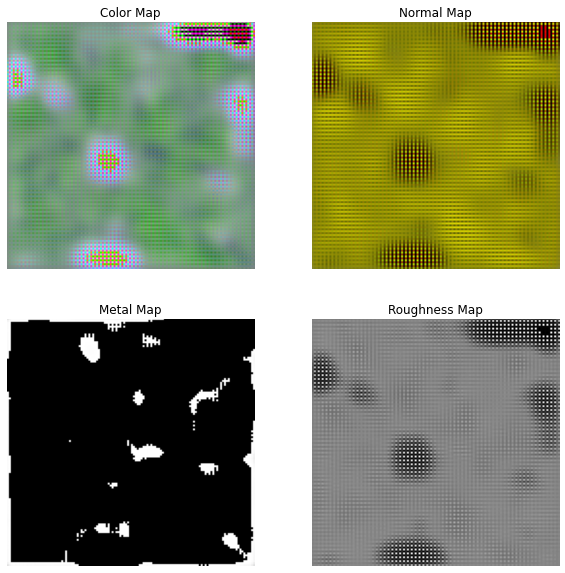

In [49]:
random_latent_vectors = tf.random.normal(shape=(10, 128))
generated_materials = gan.generator(random_latent_vectors)
generated_materials *= 255
generated_materials = generated_materials.numpy()
generated_materials = generated_materials.astype("int8")

plot_sample(generated_materials, 3)

In [43]:
color_map = keras.utils.array_to_img(generated_materials[0,:,:,:3])
normal_map = keras.utils.array_to_img(generated_materials[0,:,:,3:6])
metal_map = keras.utils.array_to_img(generated_materials[0,:,:,6:7])
rough_map = keras.utils.array_to_img(generated_materials[0,:,:,7:8])

color_map.save(f"generated_test/0_color.jpg")
normal_map.save(f"generated_test/0_normal.jpg")
metal_map.save(f"generated_test/0_metal.jpg")
rough_map.save(f"generated_test/0_rough.jpg")